## SIM Training by Stein's Method

In [1]:
import numpy as np
from matplotlib import pylab as plt

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, mean_squared_error

from pysim import SimRegressor

# Case 1: Sine Ridge Function

In [2]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(1)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = np.sin(np.pi*(np.dot(x, beta))) + 0.1 * np.random.randn(n_samples)

The best hyperparameter combination can be selected via cross-validation

In [5]:
%%time 

param_grid = {"method": ["first_order", "second_order", "first_order_thres", "marginal_regression", "ols"],
              "knot_dist": ["uniform", "quantile"],
              "reg_lambda": [0.1, 0.2, 0.3, 0.4, 0.5], 
              "reg_gamma": np.logspace(0, 2, 5)}
grid = GridSearchCV(SimRegressor(spline="smoothing_spline", degree=3, knot_num=10, random_state=0), iid=False,
                    cv=KFold(3, shuffle=True, random_state=0), param_grid=param_grid, n_jobs=-1, verbose=2, error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 250 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 237 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 520 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:   12.4s finished
/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


CPU times: user 6.18 s, sys: 8.8 s, total: 15 s
Wall time: 13.1 s


In [6]:
grid.best_params_

{'knot_dist': 'uniform',
 'method': 'first_order_thres',
 'reg_gamma': 1.0,
 'reg_lambda': 0.1}

**NB**: The first-order Setin's method is selected, as $\mathbb{E}[f^{\prime\prime}(u)]=0$. Therefore, the second order method cannot provide any information about the projection coefficients. 

In this case, the first-order Setin's method is selected. 

In [7]:
clf = grid.best_estimator_
clf

SimRegressor(knot_dist='uniform', method='first_order_thres', reg_gamma=1.0)

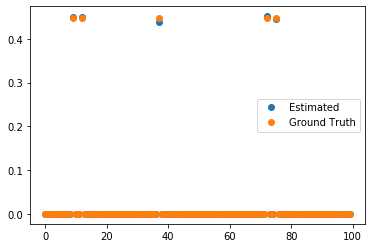

In [8]:
plt.plot(np.abs(clf.beta_), "o")
plt.plot(np.abs(beta), "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

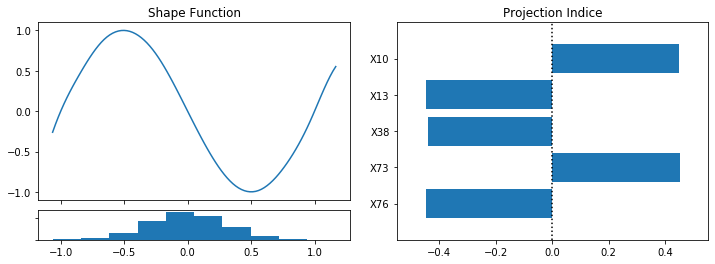

In [9]:
clf.visualize()

## Case 2: Quadratic Ridge Function

In [10]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(1)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = np.dot(x, beta) ** 2 + 0.1 * np.random.randn(n_samples)

In [11]:
%%time

param_grid = {"method": ["first_order", "second_order", "first_order_thres", "marginal_regression", "ols"],
              "knot_dist": ["uniform", "quantile"],
              "reg_lambda": [0.1, 0.2, 0.3, 0.4, 0.5], 
              "reg_gamma": np.logspace(-9, -1, 9)}
grid = GridSearchCV(SimRegressor(spline="smoothing_spline", degree=3, knot_num=10, random_state=0), iid=False,
                    cv=KFold(3, shuffle=True, random_state=0), param_grid=param_grid, n_jobs=-1, verbose=2, error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 450 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 237 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 520 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 885 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:    7.6s finished
/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


CPU times: user 9.26 s, sys: 11 s, total: 20.3 s
Wall time: 7.93 s


In [12]:
grid.best_params_

{'knot_dist': 'uniform',
 'method': 'second_order',
 'reg_gamma': 1e-09,
 'reg_lambda': 0.1}

**NB**: The second-order Setin's method is selected, as $\mathbb{E}[f^{\prime}(u)]=0$. Therefore, the first order method cannot provide any information about the projection coefficients. 

In [13]:
clf = grid.best_estimator_
clf

SimRegressor(knot_dist='uniform', method='second_order', reg_gamma=1e-09)

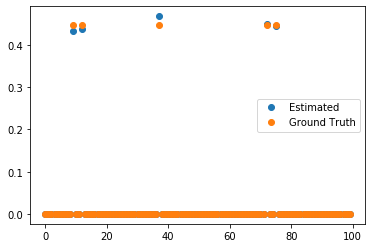

In [14]:
plt.plot(np.abs(clf.beta_), "o")
plt.plot(np.abs(beta), "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

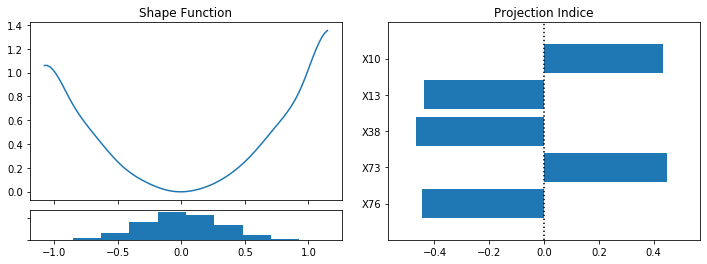

In [15]:
clf.visualize()

## Case 3: Improve a rough estimator via middle update

In [16]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(1)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.gamma(1, 0.3, size=(n_samples, n_features))
y = np.sin(np.pi*(np.dot(x, beta))) + 0.1 * np.random.randn(n_samples)

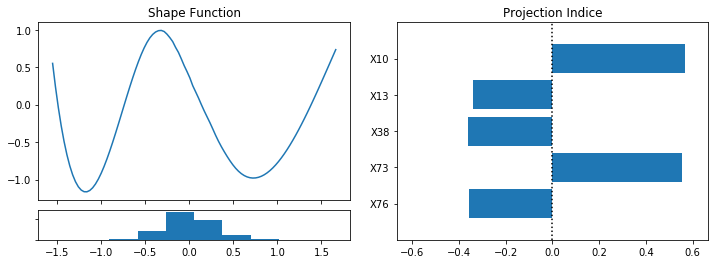

CPU times: user 3.62 s, sys: 7.12 s, total: 10.7 s
Wall time: 684 ms


In [17]:
%%time

clf = SimRegressor(degree=3, knot_num=20, reg_lambda=0.1, reg_gamma=10**(-7), spline="smoothing_spline", random_state=0)
clf.fit(x, y)
clf.visualize()

**Remark**：The data does not follow a normal distribution, so the performance is relatively poorer, we use adam optimizer to improve the estimation.

To improve the solution, we provide two options for middle update: **adam optimizer** and **BFGS optimizer**.

In [18]:
clf = SimRegressor(degree=3, knot_num=10, reg_lambda=0.1, reg_gamma=10**(-7),
                   spline="smoothing_spline", knot_dist="uniform", random_state=0)
clf.fit(x, y)
clf.fit_middle_update(x, y, method="adam", n_middle_iter_no_change=1, n_inner_iter_no_change=3,
                     learning_rate=0.001, batch_size=1000, verbose=True)
clf.visualize()

NameError: name 'eps' is not defined

In [ ]:
clf = SimRegressor(degree=3, knot_num=10, reg_lambda=0.1, reg_gamma=10**(-7), knot_dist="uniform",
                   spline="smoothing_spline", random_state=0)
clf.fit(x, y)
clf.fit_middle_update(x, y, method="bfgs", n_middle_iter_no_change=1, n_inner_iter_no_change=20,
                     max_inner_iter=100, verbose=True)
clf.visualize()

**Remark**: fit_middle_update is currently not available for spline="p_spline" or "mono_p_spline"